<a href="https://colab.research.google.com/github/madaime2/Novel_Pollen_Phylogenetic_Placement/blob/main/01_Novelty_Detection_Simulation/00_Novelty_Detection_Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch 
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision 
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

absolute_path = os.path.dirname("/content/drive/MyDrive/Podocarpus_Final/Podocarpus_Project/")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# BEGIN HERE (NAIVE CLASSIFIER)

mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])
 
torch.manual_seed(3)
data_transforms = {
    'train': transforms.Compose([
        #transforms.RandomResizedCrop(224),
        torchvision.transforms.Resize((224,224)),
        torchvision.transforms.RandomHorizontalFlip(p=0.5),
        torchvision.transforms.RandomVerticalFlip(p=0.5),
        torchvision.transforms.RandomRotation((-90,90)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
       # transforms.Resize(256),
       torchvision.transforms.Resize((224,224)),
       # transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

data_dir = absolute_path + "/Stacks_Podocarpus_WO_Oleifolius_Train_Val/"

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=10,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

# Load C-CNN (trained on entire dataset with the exception of the pseudo-novel taxon


In [ ]:
PATH = absolute_path + "/models/C-CNN_Podocarpus_Split_04_WO_Oleifolius.pt"
model =  models.resnext101_32x8d(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names)); 
model.load_state_dict(torch.load(PATH));
#model.load_state_dict(torch.load(PATH, map_location="cpu"))
model.to(device);

## Forward-pass known cross-sectional images to extract their classification scores

In [ ]:
# Forward-Pass Images to the network to get (1) Softmax probabilities and (2) best classification prediction

# Average Logits first, then pass the new logit (average) to the softmax function

# Each instance is a subfolder containing multiple (N) cross-sectional images (slices belonging to the original image stack)


mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])


import glob
from PIL import Image

transform = transforms.Compose([
    torchvision.transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
])

def predict(model, image_dir):
    """
    """
    patch_paths = glob.glob(os.path.join(image_dir, '*'))
    images = []
    for path in patch_paths:
        image = Image.open(path).convert('RGB')
        image = transform(image)
        images.append(image)

    images = torch.stack(images, 0).to(device)
    logits = model(images)
    logits = logits.detach().cpu().numpy()
    logits = torch.tensor(logits)
    logits_mean = logits.mean(0)
    probs = torch.softmax(logits_mean, 0).detach().cpu().numpy()
    # Compute average and get final prediction
    # avg_probs = probs.mean(0)
    avg_probs = probs
    final_pred = avg_probs.argmax()
    return final_pred, avg_probs

val_dir = absolute_path + "/Stacks_Podocarpus_WO_Oleifolius_Train_Val/val"

val_class_dirs = glob.glob(os.path.join(val_dir, '*'))
model.eval()
class_map = {name: idx for idx, name in enumerate(class_names)}
results = []
all_preds = []
labels = []
all_image_dirs = []

for d in val_class_dirs:
    image_dirs = glob.glob(os.path.join(d, '*'))
    for image_dir in image_dirs:
        class_name = os.path.basename(image_dir).split('.')[0]
        label = class_map[class_name]
        labels.append(label)
        all_image_dirs.append(image_dir)  
        class_id, probs = predict(model, image_dir)
        all_preds.append(probs)
        results.append((image_dir, class_id))
        #print(f'Predict {image_dir} as class {class_id}')

all_preds = np.stack(all_preds, 0)
labels = np.array(labels)
print(all_preds.shape, all_preds.dtype, labels.shape, labels.dtype)
print('Accuracy: {}'.format((all_preds.argmax(1) == labels).mean()))

(96, 29) float32 (96,) int64
Accuracy: 0.90625


In [ ]:
# Concatenate Cross-Sectional Image Directories and Softmax Probabilities, and Get SORTED Probability vectors
import numpy as np 
Dirs_and_Scores = {}
for i in range (len(all_image_dirs)):
  array_dir = all_image_dirs[i]
  array_pred = all_preds[i]
  Dirs_and_Scores[array_dir] = array_pred
  #Dirs_and_Scores.append(Dir_and_Score)
  
Stack_Probs_Sorted = []
for key in sorted(Dirs_and_Scores.keys()) :
   #print(key , " :: " , Dirs_and_Scores[key])
   #Dirs_and_Scores[key]
   Stack_Probs_Sorted.append(Dirs_and_Scores[key])

#Sort Cross-Sectional Image Labels 
labels.sort()
StackLabels = labels

In [ ]:
# Save scores of known cross-sectional images
C_CNN_Scores_Known = torch.tensor(Stack_Probs_Sorted)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  


## Forward-pass unknown (pseudo-novel) cross-sectional images to extract their classification scores

In [ ]:
# Forward-Pass Images to the network to get (1) Softmax probabilities and (2) best classification prediction

# Average Logits first, then pass the new logit (average) to the softmax function

# Each instance is a subfolder containing multiple (N) cross-sectional images (slices belonging to the original image stack)

mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

import glob
from PIL import Image

transform = transforms.Compose([
    torchvision.transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
])

def predict(model, image_dir):
    """
    """
    patch_paths = glob.glob(os.path.join(image_dir, '*'))
    images = []
    for path in patch_paths:
        image = Image.open(path).convert('RGB')
        image = transform(image)
        images.append(image)

    images = torch.stack(images, 0).to(device)
    logits = model(images)
    logits = logits.detach().cpu().numpy()
    logits = torch.tensor(logits)
    logits_mean = logits.mean(0)
    probs = torch.softmax(logits_mean, 0).detach().cpu().numpy()
    # Compute average and get final prediction
    # avg_probs = probs.mean(0)
    avg_probs = probs
    final_pred = avg_probs.argmax()
    return final_pred, avg_probs

val_dir = absolute_path + "/Pseudonovel_Oleifolius/Cross_Sections_Oleifolius/"

val_class_dirs = glob.glob(os.path.join(val_dir, '*'))
model.eval()
#class_map = {name: idx for idx, name in enumerate(class_names)}
results = []
all_preds = []
labels = []
all_image_dirs = []

for d in val_class_dirs:
    image_dirs = glob.glob(os.path.join(d, '*'))
    for image_dir in image_dirs:
        class_name = os.path.basename(image_dir).split('.')[0]
        #label = class_map[class_name]
        labels.append(label)
        all_image_dirs.append(image_dir)  
        class_id, probs = predict(model, image_dir)
        all_preds.append(probs)
        results.append((image_dir, class_id))

all_preds = np.stack(all_preds, 0)
labels = np.array(labels)

In [ ]:
# Concatenate Cross-Sectional Image Directories and Softmax Probabilities, and Get SORTED Probability vectors
import numpy as np 
Dirs_and_Scores = {}
for i in range (len(all_image_dirs)):
  array_dir = all_image_dirs[i]
  array_pred = all_preds[i]
  Dirs_and_Scores[array_dir] = array_pred
  #Dirs_and_Scores.append(Dir_and_Score)
  
Stack_Probs_Sorted = []
for key in sorted(Dirs_and_Scores.keys()) :
   #print(key , " :: " , Dirs_and_Scores[key])
   #Dirs_and_Scores[key]
   Stack_Probs_Sorted.append(Dirs_and_Scores[key])

#Sort Cross-Sectional Image Labels 
labels.sort()
StackLabels = labels

In [ ]:
# Save scores of unknown (pseudo-novel) cross-sectional images
C_CNN_Scores_Unknown = torch.tensor(Stack_Probs_Sorted)

# Load H-CNN (trained on entire dataset with the exception of the pseudo-novel taxon)


In [ ]:
PATH = absolute_path + "/models/H-CNN_Podocarpus_Split_04_WO_Oleifolius.pt"
model =  models.resnext101_32x8d(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names)); 
model.load_state_dict(torch.load(PATH));
#model.load_state_dict(torch.load(PATH, map_location="cpu"))
model.to(device);

## Forward-pass known MIP images to extract their classification scores

In [ ]:
# Forward-Pass Images to the network to get (1) Softmax probabilities and (2) best classification prediction

# Average Logits first, then pass the new logit (average) to the softmax function

# Each instance is a subfolder containing a maximum intensity projection (MIP) image


mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])


import glob
from PIL import Image

transform = transforms.Compose([
    torchvision.transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
])

def predict(model, image_dir):
    """
    """
    patch_paths = glob.glob(os.path.join(image_dir, '*'))
    images = []
    for path in patch_paths:
        image = Image.open(path).convert('RGB')
        image = transform(image)
        images.append(image)

    images = torch.stack(images, 0).to(device)
    logits = model(images)
    logits = logits.detach().cpu().numpy()
    logits = torch.tensor(logits)
    logits_mean = logits.mean(0)
    probs = torch.softmax(logits_mean, 0).detach().cpu().numpy()
    # Compute average and get final prediction
    # avg_probs = probs.mean(0)
    avg_probs = probs
    final_pred = avg_probs.argmax()
    return final_pred, avg_probs

val_dir = absolute_path + "/Images_Podocarpus_WO_Oleifolius_Train_Val/val"

val_class_dirs = glob.glob(os.path.join(val_dir, '*'))
model.eval()
class_map = {name: idx for idx, name in enumerate(class_names)}
results = []
all_preds = []
labels = []
all_image_dirs = []

for d in val_class_dirs:
    image_dirs = glob.glob(os.path.join(d, '*'))
    for image_dir in image_dirs:
        class_name = os.path.basename(image_dir).split('.')[0]
        label = class_map[class_name]
        labels.append(label)
        all_image_dirs.append(image_dir)  
        class_id, probs = predict(model, image_dir)
        all_preds.append(probs)
        results.append((image_dir, class_id))
        #print(f'Predict {image_dir} as class {class_id}')

all_preds = np.stack(all_preds, 0)
labels = np.array(labels)
print(all_preds.shape, all_preds.dtype, labels.shape, labels.dtype)
print('Accuracy: {}'.format((all_preds.argmax(1) == labels).mean()))

(96, 29) float32 (96,) int64
Accuracy: 0.5416666666666666


In [ ]:
# Concatenate Cross-Sectional Image Directories and Softmax Probabilities, and Get SORTED Probability vectors
import numpy as np 
Dirs_and_Scores = {}
for i in range (len(all_image_dirs)):
  array_dir = all_image_dirs[i]
  array_pred = all_preds[i]
  Dirs_and_Scores[array_dir] = array_pred
  #Dirs_and_Scores.append(Dir_and_Score)
  
Image_Probs_Sorted = []
for key in sorted(Dirs_and_Scores.keys()) :
   #print(key , " :: " , Dirs_and_Scores[key])
   #Dirs_and_Scores[key]
   Image_Probs_Sorted.append(Dirs_and_Scores[key])

#Sort Cross-Sectional Image Labels 
labels.sort()
ImageLabels = labels

In [ ]:
# Save scores of known cross-sectional images
H_CNN_Scores_Known = torch.tensor(Image_Probs_Sorted)

## Forward-pass unknown (pseudo-novel) MIP images to extract their classification scores

In [ ]:
# Forward-Pass Images to the network to get (1) Softmax probabilities and (2) best classification prediction

# Average Logits first, then pass the new logit (average) to the softmax function

# Each instance is a subfolder containing a maximum intensity projection (MIP) image

mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

import glob
from PIL import Image

transform = transforms.Compose([
    torchvision.transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
])

def predict(model, image_dir):
    """
    """
    patch_paths = glob.glob(os.path.join(image_dir, '*'))
    images = []
    for path in patch_paths:
        image = Image.open(path).convert('RGB')
        image = transform(image)
        images.append(image)

    images = torch.stack(images, 0).to(device)
    logits = model(images)
    logits = logits.detach().cpu().numpy()
    logits = torch.tensor(logits)
    logits_mean = logits.mean(0)
    probs = torch.softmax(logits_mean, 0).detach().cpu().numpy()
    # Compute average and get final prediction
    # avg_probs = probs.mean(0)
    avg_probs = probs
    final_pred = avg_probs.argmax()
    return final_pred, avg_probs

val_dir = absolute_path + "/Pseudonovel_Oleifolius/MIP_Oleifolius/"

val_class_dirs = glob.glob(os.path.join(val_dir, '*'))
model.eval()
#class_map = {name: idx for idx, name in enumerate(class_names)}
results = []
all_preds = []
labels = []
all_image_dirs = []

for d in val_class_dirs:
    image_dirs = glob.glob(os.path.join(d, '*'))
    for image_dir in image_dirs:
        class_name = os.path.basename(image_dir).split('.')[0]
        #label = class_map[class_name]
        labels.append(label)
        all_image_dirs.append(image_dir)  
        class_id, probs = predict(model, image_dir)
        all_preds.append(probs)
        results.append((image_dir, class_id))

all_preds = np.stack(all_preds, 0)
labels = np.array(labels)

In [ ]:
# Concatenate Cross-Sectional Image Directories and Softmax Probabilities, and Get SORTED Probability vectors
import numpy as np 
Dirs_and_Scores = {}
for i in range (len(all_image_dirs)):
  array_dir = all_image_dirs[i]
  array_pred = all_preds[i]
  Dirs_and_Scores[array_dir] = array_pred
  #Dirs_and_Scores.append(Dir_and_Score)
  
Image_Probs_Sorted = []
for key in sorted(Dirs_and_Scores.keys()) :
   #print(key , " :: " , Dirs_and_Scores[key])
   #Dirs_and_Scores[key]
   Image_Probs_Sorted.append(Dirs_and_Scores[key])

#Sort Cross-Sectional Image Labels 
labels.sort()
ImageLabels = labels

In [ ]:
# Save scores of unknown (pseudo-novel) cross-sectional images
H_CNN_Scores_Unknown = torch.tensor(Image_Probs_Sorted)

# Load P-CNN (trained on entire dataset with the exception of the pseudo-novel taxon


In [ ]:
PATH = absolute_path + "/models/P-CNN_Podocarpus_Split_04_WO_Oleifolius.pt"
model =  models.resnext101_32x8d(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names)); 
model.load_state_dict(torch.load(PATH));
#model.load_state_dict(torch.load(PATH, map_location="cpu"))
model.to(device);

## Forward-pass known patches to extract their classification scores

In [ ]:
# Forward Pass Images to the network to get (1) Softmax probabilities and (2) best classification prediction

# Average Logits first, then pass the new logit (average) to the softmax function

# Each instance is a subfolder containing multiple (N) patches (patches extracted from *one* image)


mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])


import glob
from PIL import Image

transform = transforms.Compose([
    torchvision.transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
])

def predict(model, image_dir):
    """
    """
    patch_paths = glob.glob(os.path.join(image_dir, '*'))
    images = []
    for path in patch_paths:
        image = Image.open(path).convert('RGB')
        image = transform(image)
        images.append(image)

    images = torch.stack(images, 0).to(device)
    logits = model(images)
    logits = logits.detach().cpu().numpy()
    logits = torch.tensor(logits)
    logits_mean = logits.mean(0)
    probs = torch.softmax(logits_mean, 0).detach().cpu().numpy()
    # Compute average and get final prediction
    # avg_probs = probs.mean(0)
    avg_probs = probs
    final_pred = avg_probs.argmax()
    return final_pred, avg_probs

val_dir = absolute_path + "/Patches_Podocarpus_WO_Oleifolius_Train_Val/val"

val_class_dirs = glob.glob(os.path.join(val_dir, '*'))
model.eval()
class_map = {name: idx for idx, name in enumerate(class_names)}
results = []
all_preds = []
labels = []
all_image_dirs = []

for d in val_class_dirs:
    image_dirs = glob.glob(os.path.join(d, '*'))
    for image_dir in image_dirs:
        class_name = os.path.basename(image_dir).split('.')[0]
        label = class_map[class_name]
        labels.append(label)
        all_image_dirs.append(image_dir)  
        class_id, probs = predict(model, image_dir)
        all_preds.append(probs)
        results.append((image_dir, class_id))
        #print(f'Predict {image_dir} as class {class_id}')

all_preds = np.stack(all_preds, 0)
labels = np.array(labels)
print(all_preds.shape, all_preds.dtype, labels.shape, labels.dtype)
print('Accuracy: {}'.format((all_preds.argmax(1) == labels).mean()))

(96, 29) float32 (96,) int64
Accuracy: 0.7708333333333334


In [ ]:
# Concatenate Cross-Sectional Image Directories and Softmax Probabilities, and Get SORTED Probability vectors
import numpy as np 
Dirs_and_Scores = {}
for i in range (len(all_image_dirs)):
  array_dir = all_image_dirs[i]
  array_pred = all_preds[i]
  Dirs_and_Scores[array_dir] = array_pred
  #Dirs_and_Scores.append(Dir_and_Score)
  
Patch_Probs_Sorted = []
for key in sorted(Dirs_and_Scores.keys()) :
   #print(key , " :: " , Dirs_and_Scores[key])
   #Dirs_and_Scores[key]
   Patch_Probs_Sorted.append(Dirs_and_Scores[key])

#Sort Cross-Sectional Image Labels 
labels.sort()
PatchLabels = labels

In [ ]:
# Save scores of known cross-sectional images
P_CNN_Scores_Known = torch.tensor(Patch_Probs_Sorted)

## Forward-pass unknown patches to extract their classification scores

In [ ]:
# Forward Pass Images to the network to get (1) Softmax probabilities and (2) best classification prediction

# Average Logits first, then pass the new logit (average) to the softmax function

# Each instance is a subfolder containing multiple (N) patches (patches extracted from *one* image)

mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

import glob
from PIL import Image

transform = transforms.Compose([
    torchvision.transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
])

def predict(model, image_dir):
    """
    """
    patch_paths = glob.glob(os.path.join(image_dir, '*'))
    images = []
    for path in patch_paths:
        image = Image.open(path).convert('RGB')
        image = transform(image)
        images.append(image)

    images = torch.stack(images, 0).to(device)
    logits = model(images)
    logits = logits.detach().cpu().numpy()
    logits = torch.tensor(logits)
    logits_mean = logits.mean(0)
    probs = torch.softmax(logits_mean, 0).detach().cpu().numpy()
    # Compute average and get final prediction
    # avg_probs = probs.mean(0)
    avg_probs = probs
    final_pred = avg_probs.argmax()
    return final_pred, avg_probs

val_dir = absolute_path + "/Pseudonovel_Oleifolius/Cross_Sections_Oleifolius/"

val_class_dirs = glob.glob(os.path.join(val_dir, '*'))
model.eval()
#class_map = {name: idx for idx, name in enumerate(class_names)}
results = []
all_preds = []
labels = []
all_image_dirs = []

for d in val_class_dirs:
    image_dirs = glob.glob(os.path.join(d, '*'))
    for image_dir in image_dirs:
        class_name = os.path.basename(image_dir).split('.')[0]
        #label = class_map[class_name]
        labels.append(label)
        all_image_dirs.append(image_dir)  
        class_id, probs = predict(model, image_dir)
        all_preds.append(probs)
        results.append((image_dir, class_id))

all_preds = np.stack(all_preds, 0)
labels = np.array(labels)

In [ ]:
# Concatenate Cross-Sectional Image Directories and Softmax Probabilities, and Get SORTED Probability vectors
import numpy as np 
Dirs_and_Scores = {}
for i in range (len(all_image_dirs)):
  array_dir = all_image_dirs[i]
  array_pred = all_preds[i]
  Dirs_and_Scores[array_dir] = array_pred
  #Dirs_and_Scores.append(Dir_and_Score)
  
Patch_Probs_Sorted = []
for key in sorted(Dirs_and_Scores.keys()) :
   #print(key , " :: " , Dirs_and_Scores[key])
   #Dirs_and_Scores[key]
   Patch_Probs_Sorted.append(Dirs_and_Scores[key])

#Sort Cross-Sectional Image Labels 
labels.sort()
PatchLabels = labels

In [ ]:
# Save scores of unknown (pseudo-novel) cross-sectional images
P_CNN_Scores_Unknown = torch.tensor(Patch_Probs_Sorted)

# Compute fused scores

In [ ]:
# Compute Fused Classification_Scores (element-wise multiplication) - Known specimens 
Fused_Scores_Known = C_CNN_Scores_Known * H_CNN_Scores_Known * P_CNN_Scores_Known

In [ ]:
# Compute Fused Classification_Scores (element-wise multiplication) - unknwon (pseudo-novel) specimens 
Fused_Scores_Unknown = C_CNN_Scores_Unknown * H_CNN_Scores_Unknown * P_CNN_Scores_Unknown

In [ ]:
# Normalize (0-1) fused scores - Known specimens
import torch
import torch.nn.functional as f
Normalized_Prob_Fused_Scores_Known = f.normalize(torch.tensor(Fused_Scores_Known), p=2, dim=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


In [ ]:
# Normalize (0-1) fused scores - Unknown specimens
import torch
import torch.nn.functional as f
Normalized_Prob_Fused_Scores_Unknown = f.normalize(torch.tensor(Fused_Scores_Unknown), p=2, dim=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


#Define Shannon Entropy

In [ ]:
# Shannon Entropy 
def myEntropy(p, dim = -1, keepdim=False):
    return -torch.where(p > 0, p * torch.log(p), p.new([0.0])).sum(dim = dim, keepdim=keepdim) 

# Compute entropy across all three modalities for both Known and Unknown specimens

In [ ]:
Entropy_C_CNN_Known = myEntropy(C_CNN_Scores_Known)
Entropy_H_CNN_Known = myEntropy(H_CNN_Scores_Known)
Entropy_P_CNN_Known = myEntropy(P_CNN_Scores_Known)
Entropy_FM_Known = myEntropy(Normalized_Prob_Fused_Scores_Known)

In [ ]:
Entropy_C_CNN_Unknown = myEntropy(C_CNN_Scores_Unknown)
Entropy_H_CNN_Unknown = myEntropy(H_CNN_Scores_Unknown)
Entropy_P_CNN_Unknown = myEntropy(P_CNN_Scores_Unknown)
Entropy_FM_Unknown = myEntropy(Normalized_Prob_Fused_Scores_Unknown)

Plot the ROC curves - In this example, we generated the ROC curve based on the fused model (FM). This model combines classification scores across all three modalities. The curve shows the performance of our model (i.e. its ability to differentiates between known versus unknown pollen specimens) at different entropy thresholds.

Text(0.5, 1.0, 'ROC Score 0.93939')

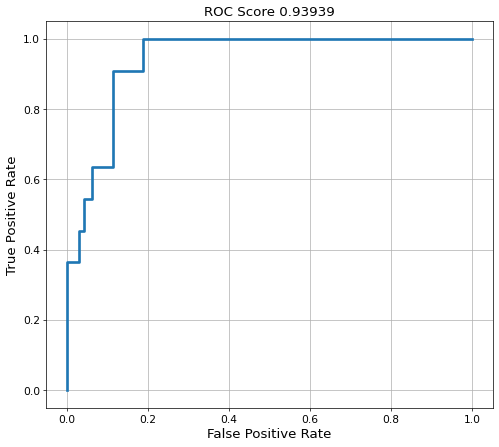

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score, f1_score
import matplotlib.pyplot as plt


def evaluate_openset(scores_closeset, scores_openset):    
    y_true = np.array([0] * len(scores_closeset) + [1] * len(scores_openset))
    y_discriminator = np.concatenate([scores_closeset, scores_openset])
    auc_d, roc_to_plot = plot_roc(y_true, y_discriminator, 'Discriminator ROC')
    return auc_d, roc_to_plot


def plot_roc(y_true, y_score, title="Receiver Operating Characteristic", **options):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    auc_score = roc_auc_score(y_true, y_score)
    roc_to_plot = {'tp':tpr, 'fp':fpr, 'thresh':thresholds, 'auc_score':auc_score}
    return auc_score, roc_to_plot

predConfscores_known = -np.array(Entropy_FM_Known)
predConfscores_novel = -np.array(Entropy_FM_Unknown)

roc_score, roc_to_plot = evaluate_openset(-predConfscores_known, -predConfscores_novel)

plt.figure(figsize=(9,8), dpi=64, facecolor='w', edgecolor='k')
ax = plt.gca()
plt.plot(roc_to_plot['fp'], roc_to_plot['tp'], linewidth=2)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
plt.grid('on')
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.title('ROC score {:.5f}'.format(roc_score), fontsize=15)

In [ ]:
roc_to_plot

{'tp': array([0.        , 0.09090909, 0.36363636, 0.36363636, 0.45454545,
        0.45454545, 0.54545455, 0.54545455, 0.63636364, 0.63636364,
        0.90909091, 0.90909091, 1.        , 1.        ]),
 'fp': array([0.        , 0.        , 0.        , 0.03125   , 0.03125   ,
        0.04166667, 0.04166667, 0.0625    , 0.0625    , 0.11458333,
        0.11458333, 0.1875    , 0.1875    , 1.        ]),
 'thresh': array([3.1006000e+00, 2.1006000e+00, 1.4142737e+00, 1.2290132e+00,
        1.1956811e+00, 1.1429478e+00, 1.0422109e+00, 8.8665843e-01,
        8.5941952e-01, 5.8310997e-01, 5.5342466e-01, 3.2582155e-01,
        2.9276037e-01, 9.6741125e-08], dtype=float32),
 'auc_score': 0.9393939393939394}

# Once the ROC curve is plotted, we can find the optimal entropy threshold that discriminates between known and unknown pollen specimens. This can be achieved by minimizing the index of union (IU) developed by Unal (2017)

In [ ]:
# Solve for lowest AUC value

# First, define variables used to minimize the IU.  

import numpy as np 
import torch
tpr = roc_to_plot['tp']

fpr = roc_to_plot['fp']

thresh = roc_to_plot['thresh']

Spe = 1 - np.array(fpr)
Sen = np.array(tpr)

auc_score = roc_to_plot['auc_score']

In [ ]:
# Define the IU and find the argument that minimizes it

IU = torch.abs(torch.tensor((Sen - auc_score))) + torch.abs(torch.tensor((Spe - auc_score)))
Diff = torch.abs(torch.tensor(Sen-Spe))
IU_minimum_index = np.where(IU == IU.min())
Diff_minimum_index = np.where(Diff == Diff.min())

if torch.numel(torch.tensor(IU_minimum_index)) == 1:
  optimal_threshold = thresh[torch.tensor(IU_minimum_index).item()]
else:
  optimal_threshold = thresh[torch.tensor(Diff_minimum_index).item()]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  


# Compute optimal Shannon entropy threshold

In [ ]:
# Optimal threshold 
print(optimal_threshold)

0.55342466


# Show optimal threshold on ROC curve

Text(0.5, 1.0, 'Novelty Detection Simulation based on the FM ($\\it{P. oleifolius}$)')

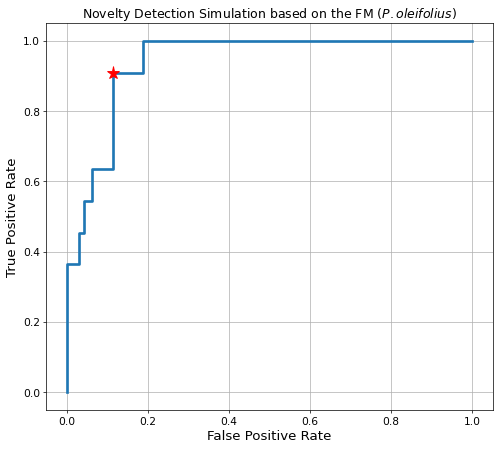

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score, f1_score
import matplotlib.pyplot as plt


def evaluate_openset(scores_closeset, scores_openset):    
    y_true = np.array([0] * len(scores_closeset) + [1] * len(scores_openset))
    y_discriminator = np.concatenate([scores_closeset, scores_openset])
    auc_d, roc_to_plot = plot_roc(y_true, y_discriminator, 'Discriminator ROC')
    return auc_d, roc_to_plot


def plot_roc(y_true, y_score, title="Receiver Operating Characteristic", **options):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    auc_score = roc_auc_score(y_true, y_score)
    roc_to_plot = {'tp':tpr, 'fp':fpr, 'thresh':thresholds, 'auc_score':auc_score}
    return auc_score, roc_to_plot

plt.figure(figsize=(9,8), dpi=64, facecolor='w', edgecolor='k')
ax = plt.gca()
plt.plot(fpr, tpr, linewidth=3)
plt.plot(fpr[10],tpr[10], 'r*', markersize=15)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
plt.grid('on')
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.title('Novelty Detection Simulation based on the FM ($\it{P. oleifolius}$)', fontsize=14)